In [13]:
corr = df.select_dtypes(include='number').corr()['song_popularity'].drop('song_popularity')
buenas_vars = corr[abs(corr) > 0.2].index.tolist()


In [14]:
X_raw = df[buenas_vars]

In [6]:
from sklearn.preprocessing import MinMaxScaler

# 1. Ver columnas numéricas solamente
X_raw = df.select_dtypes(include=['number']).drop(columns=['song_popularity'])

# 2. Escalar
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

# 3. Variable objetivo
y = df['song_popularity']
X = X_scaled


Mean Absolute Error (MAE): 13.11
Root Mean Squared Error (RMSE): 17.83
R² Score: 0.341


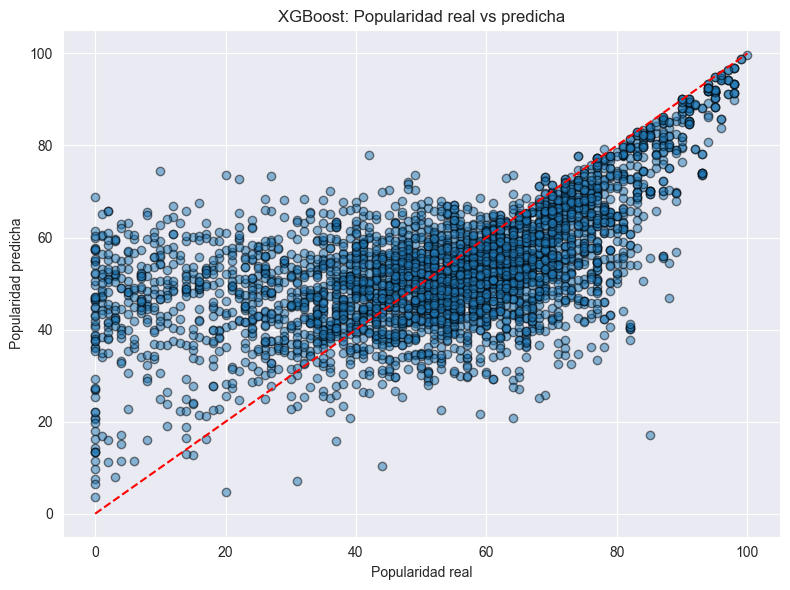

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Variables predictoras escaladas (debes asegurarte de tener este DataFrame listo)
# Por ejemplo: X_scaled = scaler.fit_transform(df[feature_columns])
# Supongo que ya tienes eso hecho
df = pd.read_csv('song_data.csv')
# Variable objetivo
y = df['song_popularity']
X = X_scaled  # Asegúrate que esto ya esté definido y tiene las mismas filas que 'y'

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear modelo de XGBoost
xgb_model = XGBRegressor(
    learning_rate=0.1,
    max_depth=8,
    n_estimators=200,
    objective='reg:squarederror',
    random_state=42
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = xgb_model.predict(X_test)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# Graficar resultados reales vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Popularidad real")
plt.ylabel("Popularidad predicha")
plt.title("XGBoost: Popularidad real vs predicha")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=10,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.3f}")


C:\Users\hp\PyCharmMiscProject\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\hp\PyCharmMiscProject\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    sel

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 15068, number of used features: 13
[LightGBM] [Info] Start training from score 53.060990
R²: 0.247


C:\Users\hp\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [12]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr[['song_popularity']].sort_values(by='song_popularity', ascending=False), annot=True)


ValueError: could not convert string to float: 'Boulevard of Broken Dreams'

In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid = GridSearchCV(XGBRegressor(objective='reg:squarederror'), params, cv=3, scoring='r2')
grid.fit(X_train, y_train)

print("Mejor modelo:", grid.best_params_)


Mejor modelo: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


In [18]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(4, 12),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5)
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Mejores hiperparámetros:", search.best_params_)
print("Mejor R² en validación cruzada:", search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores hiperparámetros: {'colsample_bytree': np.float64(0.6467440873590191), 'gamma': np.float64(0.07039911357542228), 'learning_rate': np.float64(0.06965272122664154), 'max_depth': 11, 'n_estimators': 262, 'subsample': np.float64(0.8950877702656028)}
Mejor R² en validación cruzada: 0.33299575249354046


Mean Absolute Error (MAE): 11.78
Root Mean Squared Error (RMSE): 17.18
R² Score: 0.388


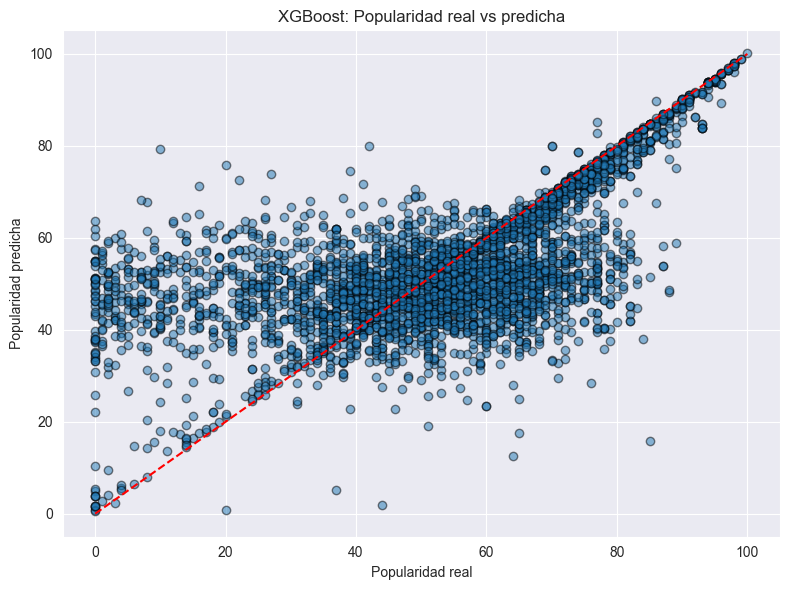

In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Variables predictoras escaladas (debes asegurarte de tener este DataFrame listo)
# Por ejemplo: X_scaled = scaler.fit_transform(df[feature_columns])
# Supongo que ya tienes eso hecho
df = pd.read_csv('song_data.csv')
# Variable objetivo
y = df['song_popularity']
X = X_scaled  # Asegúrate que esto ya esté definido y tiene las mismas filas que 'y'

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear modelo de XGBoost
xgb_model = XGBRegressor(
    colsample_bytree=0.6467,
    gamma=0.0704,
    learning_rate=0.0697,
    max_depth=11,
    n_estimators=262,
    subsample=0.8951,
    objective='reg:squarederror',
    random_state=42
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = xgb_model.predict(X_test)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# Graficar resultados reales vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Popularidad real")
plt.ylabel("Popularidad predicha")
plt.title("XGBoost: Popularidad real vs predicha")
plt.grid(True)
plt.tight_layout()
plt.show()
